# Does lungmask post processing improve metrics?

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds

In [2]:
metric_dir = "/home/local/VANDERBILT/litz/data/luna16/metrics"
johof_folds = glob.glob(os.path.join(metric_dir, "johof_norm*"))
lsm_folds = glob.glob(os.path.join(metric_dir, "lsm_*"))
model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0418cv_luna16"
# model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0506cval"
al_model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval"
kfolds_path = "/home/local/VANDERBILT/litz/data/luna16/5fold_qa.csv"
# kfolds_path = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/5folds.csv"
fold_paths = get_kfolds(kfolds_path)
al_folds = []
for d, _, _ in os.walk(al_model_dir):
    al_folds.extend(glob.glob(os.path.join(d, "lungmask_test.csv")))

johof_folds = sorted(johof_folds)
lsm_folds = sorted(lsm_folds)
al_folds = sorted(al_folds)

In [3]:
al_folds

['/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/lungmask_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold2/lungmask_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold3/lungmask_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold4/lungmask_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold5/lungmask_test.csv']

In [4]:
# parse metric csv's into dataframes
johof_df = pd.read_csv(johof_folds[0])
johof_df["fold"] = int(johof_folds[0][-5])
# johof_df["path"] = fold_paths
for i, johof_fold in enumerate(johof_folds):
    if i > 0:
        johof_fold_df = pd.read_csv(johof_fold)
        johof_fold_df["fold"] = int(johof_fold[-5])
        johof_df = pd.concat([johof_df, johof_fold_df], ignore_index=True)
# johof_df.drop(columns=['Unnamed: 0'], inplace=True)

lsm_df = pd.read_csv(lsm_folds[0])
lsm_df["fold"] = int(lsm_folds[0][-5])
for i, lsm_fold in enumerate(lsm_folds):
    if i > 0:
        lsm_fold_df = pd.read_csv(lsm_fold)
        lsm_fold_df["fold"] = int(lsm_fold[-5])
        lsm_df = pd.concat([lsm_df, lsm_fold_df], ignore_index=True)
lsm_df.drop(columns=['Unnamed: 0'], inplace=True)

al_df = pd.read_csv(al_folds[0])
al_df["fold"] = int(al_folds[0][-19])
for i, al_fold in enumerate(al_folds):
    if i > 0:
        al_fold_df = pd.read_csv(al_fold)
        al_fold_df["fold"] = int(al_fold[-19])
        al_df = pd.concat([al_df, al_fold_df], ignore_index=True)
al_df.drop(columns=['Unnamed: 0'], inplace=True)

# convert index to column to identify subjects
johof_df['id'] = johof_df.index
lsm_df['id'] = lsm_df.index
al_df['id'] = al_df.index

In [6]:
al_df

,0,1,2,3,4,input_path,fold,id
0,0.969615,0.970621,0.946400,0.785472,0.926111,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,0
1,0.975954,0.968721,0.956962,0.905993,0.966131,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,1
2,0.977585,0.976557,0.961872,0.929571,0.976269,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,2
3,0.936103,0.939107,0.937263,0.829563,0.959009,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,3
4,0.978159,0.972027,0.962354,0.878590,0.938871,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,4
...,...,...,...,...,...,...,...,...
72,0.986498,0.980315,0.974086,0.946282,0.983984,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,72
73,0.926367,0.904833,0.969792,0.951572,0.960004,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,73
74,0.987690,0.982296,0.947274,0.923763,0.976459,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,74
75,0.970379,0.940687,0.960382,0.870451,0.961880,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,75


In [33]:
pd.set_option('display.max_colwidth', None)
johof_df['model'] = 'Hof.'
lsm_df['model'] = 'LSM'
al_df['model'] = 'Proposed'
all_df = pd.concat([johof_df, lsm_df, al_df], ignore_index=True)
examples = all_df[(all_df['input_path'].str.contains("00000707time20130524"))
     | (all_df['input_path'].str.contains("00001034time20180711"))
     | (all_df['input_path'].str.contains("00001033time20181022"))]
print(examples)
examples[['0','1','2','3','4']].mean(axis=1)

     Unnamed: 0         0         1         2         3         4  fold  id  \
107         NaN  0.990341  0.987871  0.982556  0.965426  0.985218     1  13   
122         NaN  0.986162  0.985999  0.947075  0.423585  0.900983     2  28   
168         NaN  0.987690  0.982296  0.947274  0.923763  0.976459     5  74   

        model  \
107  Proposed   
122  Proposed   
168  Proposed   

                                                                                                        input_path  
107  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000707time20130524.nii.gz  
122  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001033time20181022.nii.gz  
168  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001034time20180711.nii.gz  


107    0.982282
122    0.848761
168    0.963496
dtype: float64

In [37]:
# function that maps an input int (as str type) to name of lobe
def lobe_map(x):
    if x=='0': return 'LUL'
    if x=='1': return 'LLL'
    if x=='2': return 'RUL'
    if x=='3': return 'RML'
    if x=='4': return 'RLL'

In [38]:
# convert wide to long form
johof_long = pd.melt(johof_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
johof_long['model'] = 'Hof.'
lsm_long = pd.melt(lsm_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
lsm_long['model'] = 'LSM'
# unet_long = pd.melt(unet_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
# unet_long['model'] = '3DUnet'
al_long = pd.melt(al_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
al_long['model'] = 'Proposed'

all_df = pd.concat([johof_long, lsm_long, al_long], ignore_index=True)
# # convert lobe numbers to names
all_df = all_df.rename(columns={'variable':'Lobe', 'value': 'Dice score'})
all_df['Lobe'] = all_df['Lobe'].apply(lobe_map)

In [39]:
print(all_df.groupby(['model']).mean())
print(all_df.groupby(['model']).std())
print(all_df.groupby(['model', 'Lobe']).mean())
print(all_df.groupby(['model', 'Lobe']).std())

            id      fold  Dice score
model                               
Hof.      23.0  3.085106    0.899635
LSM       23.0  3.085106    0.898225
Proposed  38.0  3.051948    0.941030
                 id      fold  Dice score
model                                    
Hof.      13.593613  1.444556    0.104568
LSM       13.593613  1.444556    0.106558
Proposed  22.255032  1.433383    0.086869
                 id      fold  Dice score
model    Lobe                            
Hof.     LLL   23.0  3.085106    0.933251
         LUL   23.0  3.085106    0.925332
         RLL   23.0  3.085106    0.938300
         RML   23.0  3.085106    0.792376
         RUL   23.0  3.085106    0.908914
LSM      LLL   23.0  3.085106    0.934729
         LUL   23.0  3.085106    0.922632
         RLL   23.0  3.085106    0.938958
         RML   23.0  3.085106    0.783988
         RUL   23.0  3.085106    0.910816
Proposed LLL   38.0  3.051948    0.964162
         LUL   38.0  3.051948    0.970040
         RLL   38

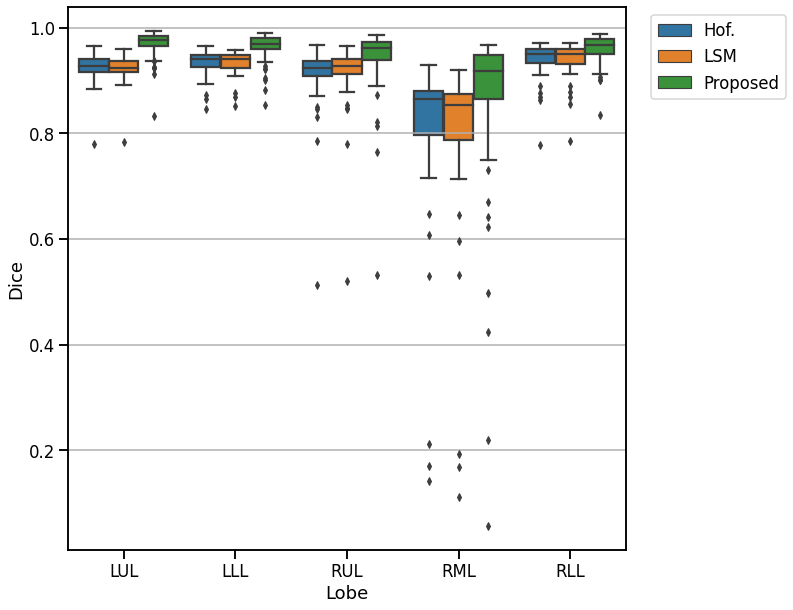

In [40]:
sns.set_context(context="talk")
hue = "model"
# hue_order = ['Hof.', 'LSM','3DUnet', 'AL']
hue_order = ['Hof.', 'LSM', 'Proposed']
order = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
f, ax = plt.subplots(figsize=(10, 10))
bplot = sns.boxplot(data=all_df, x="Lobe", y="Dice score", 
                    order=order, hue="model", hue_order=hue_order)
bplot.set(xlabel="Lobe", ylabel="Dice")
ax.yaxis.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LSM vs. Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=0.000e+00
Hof. vs. Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=0.000e+00


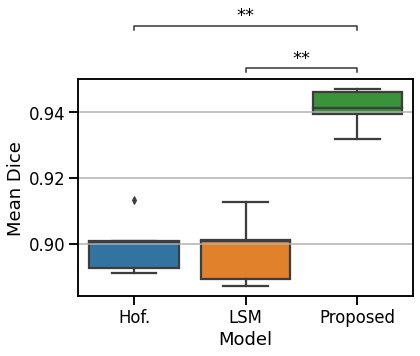

In [41]:
mean_df = all_df.groupby(["fold", "model"], as_index=False).agg({"Dice score": "mean"})
# mean_3dunet = mean_df[mean_df["model"]=="3DUnet"]["Dice score"].values
mean_hof = mean_df[mean_df["model"]=="Hof."]["Dice score"].values
mean_lsm = mean_df[mean_df["model"]=="LSM"]["Dice score"].values
mean_lsm = mean_df[mean_df["model"]=="Proposed"]["Dice score"].values

# w, p = wilcoxon(mean_3dunet, mean_hof, alternative="greater")
# print(f'3dunet, hof: {w}, {p}')
# w, p = wilcoxon(mean_3dunet, mean_lsm, alternative="greater")
# print(f'3dunet, lsm: {w}, {p}')
# w, p = wilcoxon(mean_lsm, mean_hof, alternative="two-sided")
# print(f'lsm, hof: {w}, {p}')


# plot stat significance
# order = ['Hof.', 'LSM','3DUnet', 'AL']
order = ['Hof.', 'LSM', 'Proposed']
pairs = [('Proposed', 'Hof.'), ('Proposed', 'LSM')]

f, ax = plt.subplots()
bplot = sns.boxplot(x="model", y="Dice score", data=mean_df, orient="v", order=order, hue_order=order)
bplot.set(xlabel="Model", ylabel="Mean Dice")
ax.yaxis.grid(True)
annotator = Annotator(bplot, pairs, data=mean_df, x="model", y="Dice score", order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_test()
bplot, test_results = annotator.annotate()

In [43]:
import math
table1 = all_df.groupby(['model'], as_index=False).agg(mean=("Dice score", "mean"), count=("Dice score", "count"), std=("Dice score","std"))
print(table1)
ci95_hi = []
ci95_lo = []

for i in table1.index:
    _, m, c, s = table1.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

table1['ci95_lo'] = ci95_lo
table1['ci95_hi'] = ci95_hi
print(table1)

      model      mean  count       std
0      Hof.  0.899635    235  0.104568
1       LSM  0.898225    235  0.106558
2  Proposed  0.941030    385  0.086869
      model      mean  count       std   ci95_lo   ci95_hi
0      Hof.  0.899635    235  0.104568  0.886265  0.913004
1       LSM  0.898225    235  0.106558  0.884600  0.911849
2  Proposed  0.941030    385  0.086869  0.932353  0.949708


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LLL_LSM vs. LLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:5.144e-12 U_stat=4.690e+02
RUL_LSM vs. RUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.920e-08 U_stat=7.180e+02
RML_LSM vs. RML_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.036e-07 U_stat=7.760e+02
RLL_LSM vs. RLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.224e-06 U_stat=8.670e+02
LUL_LSM vs. LUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:9.766e-17 U_stat=1.960e+02
RUL_Hof. vs. RUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.340e-08 U_stat=7.060e+02
RML_Hof. vs. RML_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:8.489e-07 U_stat=8.530e+02
RLL_Hof. vs. RLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.075e-06 U_stat=8.620e+02
LLL_Hof. vs. LLL_Proposed: Mann-Whitney-

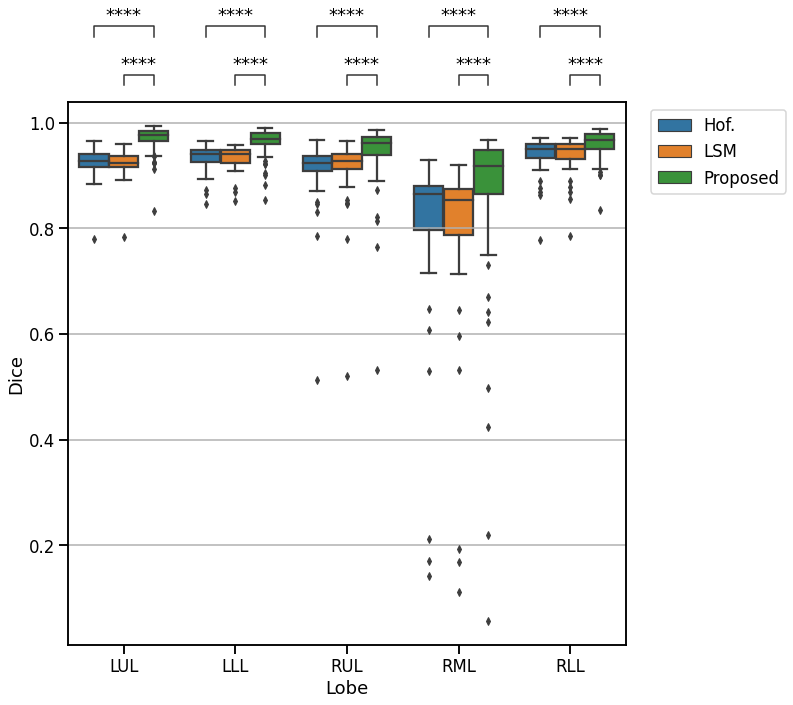

In [21]:
# paired wilcoxon signed rank test of performance on individual lobes for all examples
all_sorted = all_df.sort_values(["id", "model", "Lobe"])
# print(all_sorted[:30])
# all_3dunet = all_sorted[all_sorted["model"]=="3DUnet"]["Dice score"].values
all_hof = all_sorted[all_sorted["model"]=="Hof."]["Dice score"].values
all_lsm = all_sorted[all_sorted["model"]=="LSM"]["Dice score"].values

# w, p = wilcoxon(all_3dunet, all_hof, alternative="greater")
# print(f'3dunet, hof: {w}, {p}')
# w, p = wilcoxon(all_3dunet, all_lsm, alternative="greater")
# print(f'3dunet, lsm: {w}, {p}')
# w, p = wilcoxon(all_hof, all_lsm, alternative="two-sided")
# print(f'lsm, hof: {w}, {p}')

hue = "model"
# hue_order = ['Hof.', 'LSM', '3DUnet', 'AL']
hue_order = ['Hof.', 'LSM', 'Proposed']
order = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
f, ax = plt.subplots(figsize=(10, 10))
bplot = sns.boxplot(data=all_sorted, x="Lobe", y="Dice score", 
                    order=order, hue="model", hue_order=hue_order)
bplot.set(xlabel="Lobe", ylabel="Dice")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.yaxis.grid(True)
# plot stat significance
pairs=[(('LUL', 'Proposed'), ('LUL', 'Hof.')),
       (('LUL', 'Proposed'), ('LUL', 'LSM')),
       (('LLL', 'Proposed'), ('LLL', 'Hof.')),
       (('LLL', 'Proposed'), ('LLL', 'LSM')),
       (('RUL', 'Proposed'), ('RUL', 'Hof.')),
       (('RUL', 'Proposed'), ('RUL', 'LSM')),
       (('RML', 'Proposed'), ('RML', 'Hof.')),
       (('RML', 'Proposed'), ('RML', 'LSM')),
       (('RLL', 'Proposed'), ('RLL', 'Hof.')),
       (('RLL', 'Proposed'), ('RLL', 'LSM')),
      ]
annotator = Annotator(bplot, pairs, data=all_sorted, x="Lobe", y="Dice score", 
                      order=order, hue=hue, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc="outside", verbose=2)
annotator.apply_test()
bplot, test_results = annotator.annotate()


In [44]:
table2 = all_df.groupby(['model', 'Lobe'], as_index=False).agg(mean=("Dice score", "mean"), count=("Dice score", "count"), std=("Dice score","std"))
# print(table2)
ci95_hi = []
ci95_lo = []

for i in table2.index:
    *_, m, c, s = table2.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

table2['ci95_lo'] = ci95_lo
table2['ci95_hi'] = ci95_hi

table2 = table2.drop(['count', 'std'], axis=1)
table2.sort_values(by=['Lobe', 'model'])

,model,Lobe,mean,ci95_lo,ci95_hi
0,Hof.,LLL,0.933251,0.926320,0.940183
5,LSM,LLL,0.934729,0.928221,0.941236
10,Proposed,LLL,0.964162,0.958642,0.969682
1,Hof.,LUL,0.925332,0.917202,0.933462
6,LSM,LUL,0.922632,0.915236,0.930029
11,Proposed,LUL,0.970040,0.964738,0.975341
2,Hof.,RLL,0.938300,0.928251,0.948349
7,LSM,RLL,0.938958,0.929068,0.948847
12,Proposed,RLL,0.961302,0.955428,0.967177
3,Hof.,RML,0.792376,0.740409,0.844343
